# Twitter Sentiment Analysis

### Library Importation

```python

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from  nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

# Word2vec Library
import gensim

# Utility Libraries
from collections import Counter
import itertools
import logging
import numpy as np
import os
import pickle
import re
import string
import time



# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Constant Settings

In [2]:
# DATASET
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
# Download stopwords list from NLTK.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Mcsteve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Read Dataset

In [4]:
# Load dataset into a dataframe object.
df = pd.read_csv("labeled_stock_twts.csv", \
                encoding=DATASET_ENCODING)

In [5]:
df.head()

,Unnamed: 0,created_at,text,sentiment
0,0,2022-04-29 23:39:42+00:00,4 29 7p fr 13 016 swapped motefuker bitch loc ...,Negative
1,1,2022-04-29 21:08:54+00:00,4 29 5p th 15 7 1 1 snack replied bp bounces f...,Neutral
2,2,2022-04-29 20:33:09+00:00,astrazeneca azn q1 earnings revenues beat esti...,Positive
3,3,2022-04-29 20:18:12+00:00,bp p l c bp l stock price news quote amp histo...,Neutral
4,4,2022-04-29 18:52:43+00:00,hsbc top shareholder calls banking giant break...,Neutral


### Dataset details

* **created_at**: the date of the tweet (Fri April 29 23:39:42 UTC 2022)
* **text**: the text of the tweet (HSBC to introduce four day working week for all employees)

In [6]:
# Display size of the dataset.
print("Dataset size:", len(df))

Dataset size: 14030


In [7]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,created_at,text,sentiment
0,2022-04-29 23:39:42+00:00,4 29 7p fr 13 016 swapped motefuker bitch loc ...,Negative
1,2022-04-29 21:08:54+00:00,4 29 5p th 15 7 1 1 snack replied bp bounces f...,Neutral
2,2022-04-29 20:33:09+00:00,astrazeneca azn q1 earnings revenues beat esti...,Positive
3,2022-04-29 20:18:12+00:00,bp p l c bp l stock price news quote amp histo...,Neutral
4,2022-04-29 18:52:43+00:00,hsbc top shareholder calls banking giant break...,Neutral


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 351 ms, sys: 12.3 ms, total: 363 ms
Wall time: 399 ms


### Continue

Text(0.5, 1.0, 'Sentiment labels distribuition')

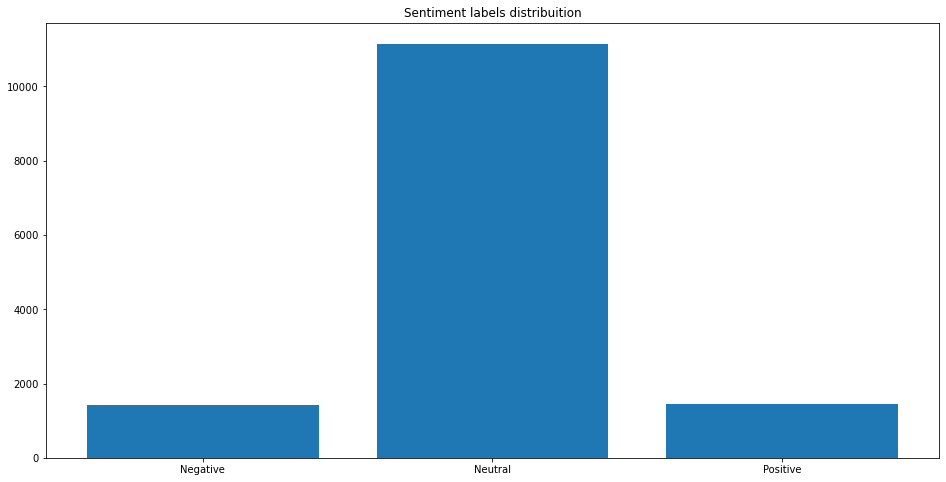

In [8]:
target_count = Counter(df.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_count.keys(), target_count.values())
plt.title("Sentiment labels distribuition")

In [9]:
df['sentiment'].value_counts()

Neutral     11151
Positive     1455
Negative     1424
Name: sentiment, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14030 entries, 0 to 14029
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  14030 non-null  object
 1   text        14030 non-null  object
 2   sentiment   14030 non-null  object
dtypes: object(3)
memory usage: 329.0+ KB


In [11]:
df.drop_duplicates(keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13958 entries, 0 to 14029
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  13958 non-null  object
 1   text        13958 non-null  object
 2   sentiment   13958 non-null  object
dtypes: object(3)
memory usage: 436.2+ KB


In [12]:
decode_map = {'Negative': 0, "Neutral": 1, "Positive": 2}
def decode_sentiment(label):
    return decode_map[label]

### Pre-Process dataset

In [13]:
# Implementing stop words and Porter Stemmer.

stop_words = stopwords.words("english")
stemmer = PorterStemmer()

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 837 ms, sys: 13.6 ms, total: 851 ms
Wall time: 901 ms


In [16]:
df.head()

,created_at,text,sentiment
0,2022-04-29 23:39:42+00:00,4 29 7p fr 13 016 swapped motefuker bitch loc ...,Negative
1,2022-04-29 21:08:54+00:00,4 29 5p th 15 7 1 1 snack replied bp bounces f...,Neutral
2,2022-04-29 20:33:09+00:00,astrazeneca azn q1 earnings revenues beat esti...,Positive
3,2022-04-29 20:18:12+00:00,bp p l c bp l stock price news quote amp histo...,Neutral
4,2022-04-29 18:52:43+00:00,hsbc top shareholder calls banking giant break...,Neutral


In [18]:
df['created_at'] = pd.to_datetime(df['created_at'])

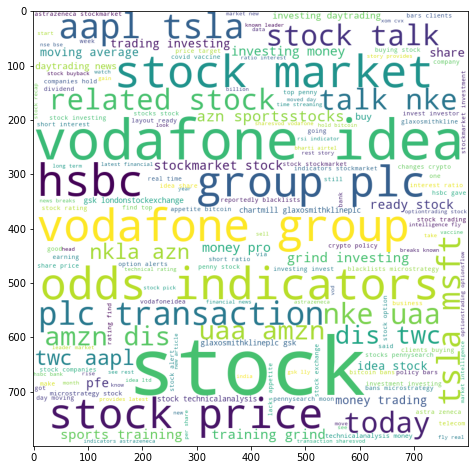

In [15]:
stopword = set(STOPWORDS) | set(['basketball', 'view', 'mrna', 'rt', 'amp', 'kodk', 'nflx'])
Unfiltered=df["text"]
Unfiltered = Unfiltered.str.cat(sep='')
# Create WordCloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopword,
                      min_font_size=10,
                      regexp=r"\w{3,}"
                      ).generate(Unfiltered)


plt.figure(figsize=(12, 8), facecolor=None)
plt.imshow(wordcloud)

### Train, Test Split

In [19]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 11166
TEST size: 2792


### Word2Vec 

In [20]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 27.3 ms, sys: 10.3 ms, total: 37.6 ms
Wall time: 53.1 ms


In [21]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-09-15 14:03:11,862 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-09-15T14:03:11.815364', 'gensim': '4.2.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [22]:
w2v_model.build_vocab(documents)

2022-09-15 14:03:15,611 : INFO : collecting all words and their counts
2022-09-15 14:03:15,614 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-09-15 14:03:15,679 : INFO : PROGRESS: at sentence #10000, processed 179563 words, keeping 16891 word types
2022-09-15 14:03:15,686 : INFO : collected 17918 word types from a corpus of 200645 raw words and 11166 sentences
2022-09-15 14:03:15,687 : INFO : Creating a fresh vocabulary
2022-09-15 14:03:15,708 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 2695 unique words (15.04% of original 17918, drops 15223)', 'datetime': '2022-09-15T14:03:15.708669', 'gensim': '4.2.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2022-09-15 14:03:15,709 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 167945 word corpus (83.70% of original 200645, drops 32700)', 'datetime': '2022-09-15T

In [23]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2695


In [24]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-09-15 14:03:33,472 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 2695 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-09-15T14:03:33.472028', 'gensim': '4.2.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
2022-09-15 14:03:33,666 : INFO : EPOCH 0: training on 200645 raw words (145178 effective words) took 0.2s, 836030 effective words/s
2022-09-15 14:03:33,863 : INFO : EPOCH 1: training on 200645 raw words (145388 effective words) took 0.2s, 823895 effective words/s
2022-09-15 14:03:34,046 : INFO : EPOCH 2: training on 200645 raw words (145270 effective words) took 0.2s, 848565 effective words/s
2022-09-15 14:03:34,270 : INFO : EPOCH 3: training on 200645 raw words (145382 effective words) took 0.2s, 723506 effective words/s
2022-09-15 14:03:34,467 : INFO : EPOCH 4: training on 200645 raw words (1

CPU times: user 15.2 s, sys: 250 ms, total: 15.5 s
Wall time: 6.13 s


(4649942, 6420640)

In [29]:
w2v_model.wv.most_similar("hsbc")

[('bond', 0.49708443880081177),
 ('asset', 0.46936744451522827),
 ('chinese', 0.4582306146621704),
 ('meta', 0.41251301765441895),
 ('currency', 0.40890172123908997),
 ('citizens', 0.40813112258911133),
 ('euros', 0.3945108950138092),
 ('asia', 0.3939637839794159),
 ('cartel', 0.3915071189403534),
 ('valuation', 0.390511691570282)]

### Tokenize Text

In [30]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 17919
CPU times: user 263 ms, sys: 10.4 ms, total: 273 ms
Wall time: 315 ms


In [31]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 274 ms, sys: 10.6 ms, total: 285 ms
Wall time: 327 ms


In [32]:
type(x_train)

numpy.ndarray

### Label Encoder for Target label encoding

In [33]:
labels = df_train.sentiment.unique().tolist()
labels

['Neutral', 'Positive', 'Negative']

In [35]:
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (11166, 1)
y_test (2792, 1)


In [36]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print()
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (11166, 300)
y_train: (11166, 1)

x_test: (2792, 300)
y_test: (2792, 1)


In [42]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [37]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(17919, 300)


In [38]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [39]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-09-15 14:11:56.014485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          5375700   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,536,201
Trainable params: 160,501
Non-trainable params: 5,375,700
_________________________________________________________________


### Compile model

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [41]:
# Change patience to 2 or 3; val_acc to val_accuracy or val_loss; Reduce epochs to 4/6.
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0, mode='auto'),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3)]

### Train

In [42]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
10/10 [==============================] - 113s 11s/step - loss: 0.3988 - accuracy: 0.7243 - val_loss: 0.0371 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 2/8
10/10 [==============================] - 111s 11s/step - loss: -0.0123 - accuracy: 0.7948 - val_loss: -0.0737 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 3/8
10/10 [==============================] - 121s 12s/step - loss: -0.1496 - accuracy: 0.7960 - val_loss: -0.2380 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 4/8
10/10 [==============================] - 105s 10s/step - loss: -0.3217 - accuracy: 0.8008 - val_loss: -0.3961 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 5/8
10/10 [==============================] - 115s 12s/step - loss: -0.4809 - accuracy: 0.7959 - val_loss: -0.5136 - val_accuracy: 0.7995 - lr: 0.0010
Epoch 6/8
10/10 [==============================] - 123s 13s/step - loss: -0.5895 - accuracy: 0.7951 - val_loss: -0.6361 - val_accuracy: 0.8013 - lr: 0.0010
CPU times: user 17min 2s, sys: 6min 49s, total: 23min 51s
Wall tim

### Evaluate

In [43]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

3/3 [==============================] - 7s 2s/step - loss: -0.7565 - accuracy: 0.7987

ACCURACY: 0.7987105846405029
LOSS: -0.7565028667449951
CPU times: user 10.6 s, sys: 2.27 s, total: 12.9 s
Wall time: 6.77 s


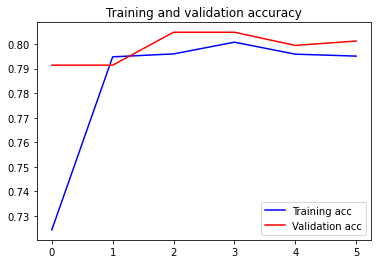

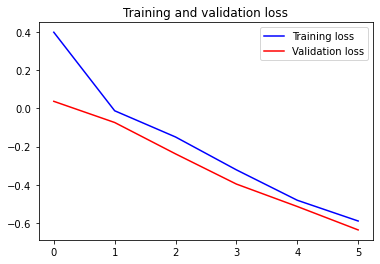

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [45]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [46]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [49]:
predict("Hsbc stock is definitely going to go down")

1/1 [==============================] - 0s 64ms/step


{'label': 'POSITIVE',
 'score': 0.998018205165863,
 'elapsed_time': 0.13733768463134766}

In [50]:
predict("I hate the rain")

1/1 [==============================] - 0s 94ms/step


{'label': 'NEUTRAL',
 'score': 0.6394203305244446,
 'elapsed_time': 0.12923717498779297}

In [51]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 57ms/step


{'label': 'NEUTRAL',
 'score': 0.6615009307861328,
 'elapsed_time': 0.1303572654724121}

### Confusion Matrix

In [53]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.sentiment)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 8s 8s/step
CPU times: user 10.5 s, sys: 3.01 s, total: 13.5 s
Wall time: 7.98 s


In [54]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

/var/folders/0m/qzs61wkd7hq22cxszn2z854h0000gp/T/ipykernel_84364/106037557.py:9: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


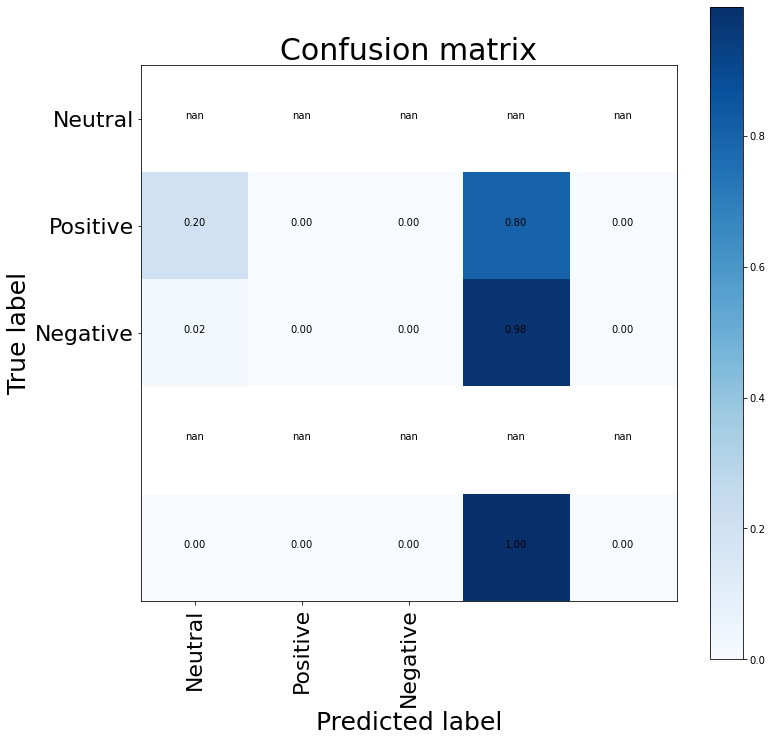

CPU times: user 268 ms, sys: 49.1 ms, total: 317 ms
Wall time: 416 ms


In [56]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [57]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00       0.0
    Negative       0.00      0.00      0.00     270.0
     Neutral       0.00      0.00      0.00    2220.0
    POSITIVE       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00     302.0

    accuracy                           0.00    2792.0
   macro avg       0.00      0.00      0.00    2792.0
weighted avg       0.00      0.00      0.00    2792.0



/Users/Mcsteve/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Mcsteve/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Mcsteve/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Mcsteve/opt/an

### Accuracy Score

In [60]:
accuracy_score(y_test_1d, y_pred_1d)

0.790721875

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)